# REGRESSION FOR ALGORITHMIC MUSIC COMPOSITION

## Extracting chords from ChordPro files of The Beatles Songs.

In this chapter, the functions used for parsing ChordPro files were defined. An organized library version of the functions also can be found in the repository: https://github.com/aysimakarca/chordpro. 

Data used was collected from http://getsome.org/guitar/olga/chordpro/b/Beatles/

In [1]:
import re
import os
import numpy as np
import matplotlib.pyplot as plt
import time
from pychord import Chord

Here we define the unique note names as the limited characters which an chord can start with.

In [2]:
uniqueChordNames = ["A","B", "C", "D", "E", "F", "G"]       


The functions below are part of ChordPro parsing features. Here we extract special information like chorus, intro, title, key and using them in the creation of Song object below. 

In [3]:
def readChordProFile(chordProFile):
    with open(chordProFile, 'r') as file:
        print(chordProFile)
        content = file.read()
        return content

In [4]:
def cleanChords(chords):
    finalChords = []
    for chord in chords:
        chord = chord.replace("H", "B")
        chord = chord.replace("b", "-")
        chord = chord.replace("min", "m")
        chord = chord.replace("maj", "")
        chord = chord.replace("sus", "")
        chord = chord.replace("dim", "")
        if len(chord) > 3:
            chord = chord[0:3]
        chord = chord.replace("7", "")        
        chord = chord.replace("(", "")
        chord = chord.replace("+", "")
        chord = chord.replace("?", "")
        chord = chord.replace(".", "")
        chord = chord.split("/")[0]
        chord = chord.split("+")[0]
        chord = re.sub(r'\d+', '', chord)
        restWithoutAlphabethic = re.sub(r'[a-zA-Z]+', '', chord[1:]) 
        chord = chord[0] + restWithoutAlphabethic
        
        if chord[0:1] in uniqueChordNames:
            finalChords.append(chord)
    return finalChords

In [5]:
def getChordsOfALine(line, content):
    chordPattern = r'\[([^\]]+)\]'
    lineChords = []
    if "chorus}" in line.lower():
        lineChords = getChorus(content)
    elif "repeat intro}" in line.lower():
        lineChords = getIntro(content)
    elif "[" in line:
        lineChords = re.findall(chordPattern, line)   
    return lineChords

In [6]:
def getChorus(content):
    patternArr = ["{soc}(.*?){eoc}", "{start_of_chorus}(.*?){end_of_chorus}"]
    chords = []
    for pattern in patternArr:
        match = re.search(pattern, content, re.DOTALL)
        if match:
            chorus = match.group(1).strip()
            chordPattern = r"\[([^\]]*)\]"
            chords = re.findall(chordPattern, chorus)
            return chords
    return chords

In [7]:
def getIntro(content):
    chordsOfIntro = []
    inIntro = False
    for line in content.split("\n"): 
        if '{c:intro:}' in line.lower() or '{c:intro}'in line.lower():
            inIntro = True
        elif inIntro:
            lineChords = getChordsOfALine(line, content)
            if len(lineChords) > 0:
                chordsOfIntro.extend(lineChords)
            else:
                inIntro = False
                break
    return chordsOfIntro

In [8]:
def getTitle(content, chordProFile):
    pattern = r"\{title:\s*(.*?)\s*\}"
    match = re.search(pattern, content)
    title = ''
    if match:
        title = match.group(1)
    else:
        title = os.path.splitext(os.path.basename(chordProFile))[0]
    return title

In [9]:
def getKey(content):
    pattern = r"{key:\s*([A-G][#b]?)\s*}"
    match = re.search(pattern, content)
    key = ''
    if match:
        key = match.group(1)
    return key

A song class was created in order to access the chord information easily. A song object can be initialized by providing a path for the ChordPro song file and the constructor will call the functions above. It will extract the chords, chorus and other information within the song object.

In [10]:
class Song:
    def __init__(self, chordProFile):
        self.chordProFile = chordProFile
        self.content = readChordProFile(chordProFile)
        self.chorus = self.getChorus()
        self.chords = self.getChords()
        self.title = self.getTitle()
        self.key = self.getKey()
        
    def getChords(self):
        chords = []
        for line in self.content.split("\n"): 
            lineChords = getChordsOfALine(line, self.content)
            chords.extend(cleanChords(lineChords))
        return chords
    
    def getChordsBeforeChorus(self):
        chords = []
        for line in self.content.split("\n"): 
            if 'chorus' in line.lower() or '{soc}'in line.lower() or '{start_of_chorus}'in line.lower():
                break
            lineChords = getChordsOfALine(line, self.content)
            chords.extend(cleanChords(lineChords))
        return chords
        
    def getChorus(self):
        return getChorus(self.content)
    
    def getIntro(self):
        return getIntro(self.content)
    
    def getTitle(self):
        return getTitle(self.content, self.chordProFile)
    
    def getKey(self):
        return getKey(self.content)
    

## Feature extraction & data preparation for training

In this part, we are going to create feature and target arrays by using the ChordPro functions above as well as the helper functions below.

### Create a song dictionary of songs with chords

First, we start with providing a folder path where songs can be found and we are going to iterate over each song. For every file we find, we are going to initialize a Song object and add its chords into a dictionary named **songDict** where key is the song name and value is the chord array. 

In [11]:
def createChordDictFromChordProFiles(dataFolderPath):
    fileNames = os.listdir(dataFolderPath)
    chordsDict = {}
    longestChordLength = 0
    for file in fileNames:
        if '.DS_Store' in file:
            continue
        chordproFile = dataFolderPath + file
        song = Song(chordproFile)
        chordsDict[song.title] = song.chords
    return chordsDict

In [12]:
pathOfChordTxtFiles = './data/chordpro/'

songDict = createChordDictFromChordProFiles(pathOfChordTxtFiles)

./data/chordpro/HelloGoodbye.chopro
./data/chordpro/TheContinuingStoryOfBungalowBill.chopro
./data/chordpro/YellowSubmarine.chopro
./data/chordpro/StrawberryFieldsForever.2.chopro
./data/chordpro/GetBack.chopro
./data/chordpro/Blackbird.chopro
./data/chordpro/Help.chopro
./data/chordpro/ADayInALife.chopro
./data/chordpro/DontLetMeDown.chopro
./data/chordpro/FromMeToYou.chopro
./data/chordpro/SoldierOfLove.chopro
./data/chordpro/EleanorRigby.chopro
./data/chordpro/ChristmastimeIsHereAgain.chopro
./data/chordpro/WeCanWorkItOut.chopro
./data/chordpro/WithALittleHelpFromMyFriends.chopro
./data/chordpro/AllTogetherNow.chopro
./data/chordpro/LetItBe.2.chopro
./data/chordpro/TellMeWhy.chopro
./data/chordpro/Anna.chopro
./data/chordpro/AcrossTheUniverse.chopro
./data/chordpro/IAmAWalrus.chopro
./data/chordpro/TooMuchMonkeyBusiness.chopro
./data/chordpro/WithALittleHelpFromMyFriends.2.chopro
./data/chordpro/IShouldHaveKnownBetter.chopro
./data/chordpro/ICallYourName.chopro
./data/chordpro/CantB

### Map the string chord names to integer values

The chords we worked until this point are in string format. However it is better for the regression to use integer values compared to string values. So we will create two mapping functions to map chords from string to int and from int to string.

In order to do the mapping, we build a list of unique chords exists in our songs so that we can use the index as the integer value. This will also be used when mapping from int to chord names back.

In [13]:
distinctChordNames = list(sorted({ele for val in songDict.values() for ele in val}))
print(distinctChordNames)
print(len(distinctChordNames))

['A', 'A-', 'B', 'B-', 'C', 'C#', 'D', 'D#', 'E', 'E-', 'F', 'F#', 'G', 'G#']
14


In [14]:
def mapChordNamesToIndexes(chords):
    indexArr = []
    for i, chord in enumerate(chords):
        indexArr.append(distinctChordNames.index(chord))
    return indexArr

In [15]:
def mapIndexesToChordNames(indexes):
    chords = []
    for i, index in enumerate(indexes):
        chords.append(distinctChordNames[index])
    return chords

Here we ignore the songs which has less than 10 chords as they are most likely to have a wrong formatting.

In [16]:
finalChordDict = {}
for song in songDict:
        chordArray = songDict[song]
        if len(chordArray) < 10:
            print('Chords are too short, ignoring the song ' + song)
        else:   
            finalChordDict[song] = mapChordNamesToIndexes(chordArray)
        
print(finalChordDict)

Chords are too short, ignoring the song ChristmastimeIsHereAgain
Chords are too short, ignoring the song Anna
Chords are too short, ignoring the song TooMuchMonkeyBusiness
Chords are too short, ignoring the song TwistAndShout
{'Hello, Goodbye': [4, 12, 6, 8, 6, 8, 6, 12, 6, 4, 12, 4, 9, 12, 4, 10, 12, 4, 12, 6, 8, 6, 8, 6, 12, 6, 4, 12, 4, 9, 12, 4, 10, 12, 4, 12, 6, 8, 6, 8, 6, 12, 6, 4, 12, 4, 9, 12, 4, 10, 12, 4, 12, 6, 8, 6, 8, 6, 12, 6, 4, 12, 4, 9, 12, 4, 10, 12, 4, 9, 12], 'The Continuing Story of Bungalow Bill': [4, 12, 4, 10, 4, 10, 12, 0, 8, 0, 6, 0, 6, 8, 0, 4, 10, 12, 0, 4, 10, 8, 12, 0, 10, 0, 4, 10, 12, 0, 4, 10, 12, 8, 12, 0, 10, 0, 4, 10, 12, 0, 4, 10, 12, 8, 12, 0, 10], 'Yellow Submarine': [12, 6, 4, 12, 8, 0, 4, 6, 12, 6, 4, 12, 8, 0, 4, 6, 12, 6, 4, 12, 8, 0, 4, 6, 12, 6, 4, 12, 8, 0, 4, 6, 12, 6, 12, 6, 12, 6, 4, 12, 8, 0, 4, 6, 12, 6, 4, 12, 12, 6, 12, 6, 12, 6, 4, 12, 8, 0, 4, 6, 12, 6, 4, 12, 8, 0, 4, 6, 12, 6, 12, 6, 12], 'Strawberry Fields Forever': [12, 6, 9, 

### Create feature and target arrays for training

Here we create functions for two strategy 

First one is using a fixed length for each song and using this array of a song in the feature array. This is the function **getFeaturesAndTargetsOfFlatSong**

Second approach is to use window length and hop length in order to slice the chords of the songs and use each window as the feature arrays. By default, second option is selected. This is the function **getFeaturesAndTargetsByWindowAndHop**

In [17]:
def getFeatureAndTargetArrForEachWindow(chords, windowLength, hopSize, index):
    featureArray = chords[index: index + windowLength]
    targetArray = chords[index + windowLength: index + windowLength + 1]
    return featureArray, targetArray

In [18]:
def getFeaturesAndTargetsByWindowAndHop(chordsDictionary, windowSize, hopSize):
    features = np.empty((0, windowSize), dtype=np.ndarray)
    targets = np.empty((0, 1), dtype=np.ndarray)
    for song in chordsDictionary:
        chordArray = chordsDictionary[song]
        if len(chordArray) < windowSize + 1:
            print('Chords are shorter than number of targets so skipping the song: ' + song)
            continue
        indexProcessed = 0
        while len(chordArray) - indexProcessed > windowSize + 1:
            featureArr, targetArray = getFeatureAndTargetArrForEachWindow(chordArray, windowSize, hopSize, indexProcessed)
            featureArr = np.array(featureArr).reshape(1, len(featureArr))
            features = np.append(features, featureArr, axis=0)
            targetArray = np.array(targetArray).reshape(1, len(targetArray))
            targets = np.append(targets, targetArray, axis=0)
            indexProcessed = indexProcessed + hopSize

    features = np.array(features)
    targets = np.array(targets)
    print(features.shape)
    print(targets.shape)
    print('Slicing the song chords is done!')
    return features, targets

In [19]:
def fillChordArraysUntilDesiredLength(chordArr, desiredLength):
    finalArr = np.zeros(desiredLength, dtype=int)
    chordLength = len(chordArr)
    if chordLength < desiredLength:
        print('Chords are shorter than number of targets so repeating the chords: ' + song)
        quotient, remainder = divmod(desiredLength, chordLength) 
        print(str(chordLength) + " quotient " + str(quotient) + " remainder " + str(remainder))
        for step in range(quotient):
            finalArr[step*chordLength:(step+1)*chordLength] = chordArr
        finalArr[chordLength*quotient: desiredLength] = chordArr[0:remainder]
        print(len(finalArr))
    elif chordLength > desiredLength:
        finalArr = chordArr[0: desiredLength]
    else:
        finalArr = chordArr
    print(len(finalArr))
    print(finalArr)
    return finalArr

In [20]:
def getFeaturesAndTargetsOfFlatSong(chordsDictionary, desiredFeatureLength):
    features = np.zeros((len(chordsDictionary),desiredFeatureLength), dtype=int)
    targets = np.zeros((len(chordsDictionary),1), dtype=int)
    for i, song in enumerate(chordsDictionary):
        chordArray = chordsDictionary[song] 
        finalChords = fillChordArraysUntilDesiredLength(chordArray, desiredFeatureLength+1)
        features[i:] = finalChords[0:desiredFeatureLength]
        targets[i:] = finalChords[desiredFeatureLength:desiredFeatureLength+1]
    print(features.shape)
    print(targets.shape)
    print('Slicing the song chords is done!')
    return features, targets

Here we define which approach we want to train our model with. Alternatively, you can comment out getFeaturesAndTargetsByWindowAndHop function and use getFeaturesAndTargetsOfFlatSong. 

**featureLength** variable decides the fixed length of the arrays and used by getFeaturesAndTargetsOfFlatSong function.

**windowSize** and **hopSize** variables are used by getFeaturesAndTargetsByWindowAndHop functiona and decides the window and hop sizes while slicing the chords.

In [21]:
windowSize = 16
hopSize = 2

featureLength = 50

featureArr, targetArr = getFeaturesAndTargetsByWindowAndHop(finalChordDict, windowSize, hopSize)
#featureArr, targetArr = getFeaturesAndTargetsOfFlatSong(finalChordDict, featureLength)
print(featureArr.shape)
print(targetArr.shape)

Chords are shorter than number of targets so skipping the song: ICallYourName
Chords are shorter than number of targets so skipping the song: IveJustSeenAFace
Chords are shorter than number of targets so skipping the song: ThatsAlrightMama
Chords are shorter than number of targets so skipping the song: TicketToRide
(1424, 16)
(1424, 1)
Slicing the song chords is done!
(1424, 16)
(1424, 1)


## Training Support Vector Machine Regression model

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn import svm
import sklearn
import pandas as pd

Here we first flatten the targets array and later we split the data by using %30 approach as test and training data.

In [23]:
targets = pd.Series(targetArr.flatten())

In [24]:
featuresTrain, featuresTest, targetTrain, targetTest = train_test_split(featureArr, targets, test_size=0.3, random_state=4)


Here we create a function which trains the SVR and returns the regression model. Later we will train many models and compare the performance by using this function.

We also have a timer in the training function which logs the training time.

In [25]:
def trainAndGetSVRModel(valueC, valueEpsilon, kernel, featuresTrain, targetTrain):
    startTime = time.time()
    regr = svm.SVR(C=valueC, epsilon=valueEpsilon, kernel=kernel)
    regr.fit(featuresTrain, targetTrain)
    endTime = time.time()
    timeSpent = endTime - startTime
    print(f"Time spent for the training is: {timeSpent:.4f} seconds, for values: " + str(valueC) + " epsilon: " + str(valueEpsilon) + " kernel " + kernel)
    return regr

**getErrorValues** function returns a row of different type of error values for the predicted values. This method used in order to print a table of different results.

In [26]:
def getErrorValues(targetTest, targetPredicted, paramName, paramValue):
    return { paramName: paramValue,
            'Mean Squared Err': '%.4f'% sklearn.metrics.mean_squared_error(targetTest, targetPredicted),
            'Mean Abs Err':  '%.4f'% sklearn.metrics.mean_absolute_error(targetTest, targetPredicted),
            'Max Err':  '%.4f'% sklearn.metrics.max_error(targetTest, targetPredicted),
            'Median Abs Err':  '%.4f'% sklearn.metrics.median_absolute_error(targetTest, targetPredicted),
            'R2 score':  '%.4f'% sklearn.metrics.r2_score(targetTest, targetPredicted),
            'Variance score':  '%.4f'% sklearn.metrics.explained_variance_score(targetTest, targetPredicted)}

In this cell we define a styling for our tables so that we can see the difference between errors better and compare better.

In [27]:
def highlight(value):
        return 'border: 1px solid black; padding: 5px'
    
def getDfWithStyle(df):
    return df.style.applymap(highlight)

#### Now we train our models with different C values from 0.05 to 50.

In [28]:
targetPredicted1 = trainAndGetSVRModel(0.05, 0.001, 'rbf', featuresTrain, targetTrain).predict(featuresTest)
targetPredicted2 = trainAndGetSVRModel(0.10, 0.001, 'rbf', featuresTrain, targetTrain).predict(featuresTest)
targetPredicted3 = trainAndGetSVRModel(1.0, 0.001, 'rbf', featuresTrain, targetTrain).predict(featuresTest)
targetPredicted4 = trainAndGetSVRModel(10.0, 0.001, 'rbf', featuresTrain, targetTrain).predict(featuresTest)
targetPredicted5 = trainAndGetSVRModel(50.0, 0.001, 'rbf', featuresTrain, targetTrain).predict(featuresTest)

Time spent for the training is: 0.0537 seconds, for values: 0.05 epsilon: 0.001 kernel rbf
Time spent for the training is: 0.0410 seconds, for values: 0.1 epsilon: 0.001 kernel rbf
Time spent for the training is: 0.0419 seconds, for values: 1.0 epsilon: 0.001 kernel rbf
Time spent for the training is: 0.0661 seconds, for values: 10.0 epsilon: 0.001 kernel rbf
Time spent for the training is: 0.1667 seconds, for values: 50.0 epsilon: 0.001 kernel rbf


In [29]:
dataC = getErrorValues(targetTest, targetPredicted1, 'C Value', '0.05')
resultCDf = pd.DataFrame(dataC, index=[0])
resultCDf.loc[len(resultCDf)] = getErrorValues(targetTest, targetPredicted2, "C Value", '0.10')
resultCDf.loc[len(resultCDf)] = getErrorValues(targetTest, targetPredicted3, "C Value", '1.00')
resultCDf.loc[len(resultCDf)] = getErrorValues(targetTest, targetPredicted4, "C Value", '10.00')
resultCDf.loc[len(resultCDf)] = getErrorValues(targetTest, targetPredicted5, "C Value", '50.00')

display(getDfWithStyle(resultCDf))

,C Value,Mean Squared Err,Mean Abs Err,Max Err,Median Abs Err,R2 score,Variance score
0,0.05,16.0423,3.3307,7.3846,2.3305,0.0061,0.0196
1,0.10,15.7942,3.3132,7.7686,2.6270,0.0215,0.0350
2,1.00,15.4241,3.2081,10.7735,2.9473,0.0444,0.0480
3,10.00,16.5587,3.1904,13.0687,2.8152,-0.0259,-0.0258
4,50.00,17.9717,3.1164,13.0185,2.3834,-0.1134,-0.1133


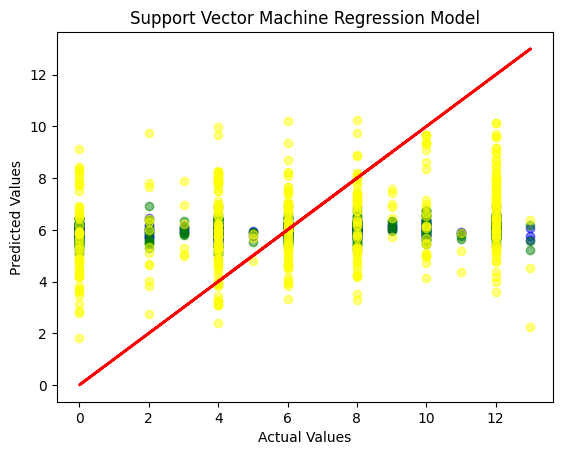

In [30]:
plt.scatter(targetTest, targetPredicted1, color='blue', label='C 0.01', alpha=0.5)
plt.scatter(targetTest, targetPredicted2, color='green', label='C 0.05', alpha=0.5)
plt.scatter(targetTest, targetPredicted3, color='yellow', label='C 0.10', alpha=0.5)
plt.plot(targetTest, targetTest, color='red', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Support Vector Machine Regression Model')
plt.show()

#### Now we train the models with different kernel functions

In [ ]:
targetPredictedByRbf = trainAndGetSVRModel(1.0, 0.001, 'rbf', featuresTrain, targetTrain).predict(featuresTest)
targetPredictedByLinear = trainAndGetSVRModel(1.0, 0.001, 'linear', featuresTrain, targetTrain).predict(featuresTest)
targetPredictedByPoly = trainAndGetSVRModel(1.0, 0.001, 'poly', featuresTrain, targetTrain).predict(featuresTest)
targetPredictedBySigmoid = trainAndGetSVRModel(1.0, 0.001, 'sigmoid', featuresTrain, targetTrain).predict(featuresTest)


Time spent for the training is: 0.0493 seconds, for values: 1.0 epsilon: 0.001 kernel rbf


In [ ]:
dataKernel = getErrorValues(targetTest, targetPredictedByRbf, 'Kernel Value', 'rbf')
resultKernelDf = pd.DataFrame(dataKernel, index=[0])
resultKernelDf.loc[len(resultKernelDf)] = getErrorValues(targetTest, targetPredictedByLinear, 'Kernel Value','linear')
resultKernelDf.loc[len(resultKernelDf)] = getErrorValues(targetTest, targetPredictedByPoly, 'Kernel Value', 'poly')
resultKernelDf.loc[len(resultKernelDf)] = getErrorValues(targetTest, targetPredictedBySigmoid, 'Kernel Value', 'sigmoid')

display(getDfWithStyle(resultKernelDf))


#### Now we train the models with different epsilon values from 0.001 to 0.1

In [ ]:
targetPredictedByEps1 = trainAndGetSVRModel(1.0, 0.001, 'rbf', featuresTrain, targetTrain).predict(featuresTest)
targetPredictedByEps2 = trainAndGetSVRModel(1.0, 0.005, 'rbf', featuresTrain, targetTrain).predict(featuresTest)
targetPredictedByEps3 = trainAndGetSVRModel(1.0, 0.010, 'rbf', featuresTrain, targetTrain).predict(featuresTest)
targetPredictedByEps4 = trainAndGetSVRModel(1.0, 0.050, 'rbf', featuresTrain, targetTrain).predict(featuresTest)
targetPredictedByEps5 = trainAndGetSVRModel(1.0, 0.100, 'rbf', featuresTrain, targetTrain).predict(featuresTest)


In [ ]:
dataEpsion = getErrorValues(targetTest, targetPredictedByEps1, "Epsilon Value", '0.001')
resultEpsilonDf = pd.DataFrame(dataEpsion, index=[0])
resultEpsilonDf.loc[len(resultEpsilonDf)] = getErrorValues(targetTest, targetPredictedByEps2, "Epsilon Value", '0.005')
resultEpsilonDf.loc[len(resultEpsilonDf)] = getErrorValues(targetTest, targetPredictedByEps3, "Epsilon Value", '0.010')
resultEpsilonDf.loc[len(resultEpsilonDf)] = getErrorValues(targetTest, targetPredictedByEps4, "Epsilon Value", '0.050')
resultEpsilonDf.loc[len(resultEpsilonDf)] = getErrorValues(targetTest, targetPredictedByEps5, "Epsilon Value", '0.100')

display(getDfWithStyle(resultEpsilonDf))


## Train and Predict next n chords for given song

In this chapter, we will use the best performed values in the previous trainings and train a model with the feature and target arrays we extracted from The Beatles.

The goal is getting a song and composing a new chorus for the song by using this model.

First we need a function to fit the chords played before chorus in the song to our feature array rows. The function **prepareSongForPrediction** gets the chords played before the chorus, whole chords of the song and the feature length. 

If there is not enough chords played before the chorus, we add chords using the chords in the song starting by the end of the song. 
If the chords played before chorus is longer than our feature length, then we throw the chords away from the beginning.

In [ ]:
def prepareSongForPrediction(beginningChords, fullChords, featureSize):
    finalArr = np.zeros((1, featureSize), dtype=int)
    lengthOfBeginning = len(beginningChords)
    lengthOfFullSong = len(fullChords)
    if lengthOfBeginning < featureSize:
        chordArray = np.zeros(featureSize, dtype=int)
        print('Beginning chords are shorter than number of features, repeating the chords')
        chordArray[featureSize-lengthOfBeginning:featureSize] = beginningChords
        if featureSize-lengthOfBeginning <= lengthOfFullSong:
            lengthToAdd = featureSize-lengthOfBeginning
            chordArray[0:lengthToAdd] = fullChords[lengthOfFullSong-lengthToAdd:lengthOfFullSong]
            chordArray[lengthToAdd:featureSize] = beginningChords
        else:
            quotient, remainder = divmod(featureSize-lengthOfBeginning, lengthOfFullSong) 
            print(quotient)
            print(remainder)
            chordArray[0:remainder] = chordArray[lengthOfFullSong-remainder:lengthOfFullSong]
            for step in range(quotient):
                start = remainder + step*lengthOfFullSong
                end = remainder + (step+1)*lengthOfFullSong
                chordArray[start:end] = fullChords
        finalArr[0:featureSize] = chordArray
    elif lengthOfBeginning > featureSize:
        finalArr[0:featureSize] = beginningChords[lengthOfBeginning-featureSize: lengthOfBeginning]
    else:
        finalArr[0:featureSize] = beginningChords
    print('Chords are ready for prediction.')
    return finalArr

#### Now we train the SVMR with C value of 1.0, epsilon of 0.001 and kernel of rbf

In [ ]:
regression = trainAndGetSVRModel(1.0, 0.001, 'rbf', featuresTrain, targetTrain)

Here we decide which song we like to compose the chorus for. We can change the song name by changing the **songFileName**.

Later we create a Song object with the ChordPro file and we extract the full chords, the chords played before the chorus and the original chorus of the song.

In order to use the song for prediction, we need to map the chord names to integer again by using the same functions before.

In [ ]:
#songFileName = 'AllYouNeedIsLove.chopro'
#songFileName = 'StrawberryFieldsForever.2.chopro'
songFileName = 'ObLaDiObLaDa.chopro'

songToGenerate = Song(pathOfChordTxtFiles + songFileName)
fullChords = songToGenerate.getChords()
chordsBeforeChorus = songToGenerate.getChordsBeforeChorus()

chordsBeforeChorusInt = mapChordNamesToIndexes(chordsBeforeChorus)
fullChordsInt = mapChordNamesToIndexes(fullChords)

featureOfSong = prepareSongForPrediction(chordsBeforeChorusInt, fullChordsInt, windowSize)

In this step, our feature array fronm the chosen song is ready to be used by the regression. 

We use **generatePredictedChords** function in order to call the predict function and add each chord predicted to the end of the chords played before the chorus. Every time we add the prediction to the end and remove a chord from the beginning. So that every prediction will be done on the chords together with predicted ones.

In [ ]:
def generatePredictedChords(regr, beginningChords, chordsLengthToPredict):
    featureArrLength = len(beginningChords[0:])
    predictedChords = np.zeros(chordsLengthToPredict, dtype=int)
    for i in range(chordsLengthToPredict):
        nextValue = int(regr.predict(beginningChords))
        predictedChords[i] = nextValue
        beginningChords = np.roll(beginningChords, -1, axis=1)
        beginningChords[:, -1] = nextValue
        print(beginningChords)
    print('Done, chords predicted: ')
    print(predictedChords)
    return predictedChords

Now we run the functions and print both the original chorus and composed chorus by regression.

In [ ]:
chorus = songToGenerate.getChorus()
chorusLengthToPredict = len(chorus)

composedChords = generatePredictedChords(regression, featureOfSong, chorusLengthToPredict)
chordNamesOfComposition = mapIndexesToChordNames(composedChords)

print('Original chorus: ', chorus)
print('Composed chorus: ', chordNamesOfComposition)

### Lets listen the midi file of composed chords

Lets convert the composition to a listenable format. In this case we will create a Acoustic Grand Piano which plays the chords where each chord is played for 500 milliseconds. 

The output will be saved as a midi file with the name of the song together with '-composed-chorus.mid' and it can be found and listened under the composed_midi folder.

In [ ]:
from pychord import Chord
import pretty_midi


def createMidi(chordNamesOfComposition, songFileName):
    chords = [Chord(c) for c in chordNamesOfComposition]
    midi = pretty_midi.PrettyMIDI()
    pianoProgram = pretty_midi.instrument_name_to_program('Acoustic Grand Piano')
    piano = pretty_midi.Instrument(program=pianoProgram)
    length = 1
    for n, chord in enumerate(chords):
        for noteName in chord.components_with_pitch(root_pitch=4):
            noteNumber = pretty_midi.note_name_to_number(noteName)
            note = pretty_midi.Note(velocity=100, pitch=noteNumber, start=n * length, end=(n + 1) * length)
            piano.notes.append(note)
    midi.instruments.append(piano)
    midi.write('./composed_midi/' + songFileName+ '-composed-chorus.mid')


createMidi(chordNamesOfComposition, songFileName)

## Create an Http POST API

In order to examine the SVMR for real time algorithmic composition purposes, I have created an HTTP POST API.

In order to use the API, providing a flat array of chord names and the length of the new composed chords are the only values needed.

The API uses the chord array for training a new model by using window length of 16 and hop size of 2 and runs predictions for the same array.

The composed chords are returned as the response in array of chord names. In live coding or other algorithmic composition performances, this API can be called iteratively many times as it is responsing very quickly.

Also for us to listen, I have also created a midi file of piano instrument playing the chords in the api. So after the api is run, the idi file named composedArray can be listened.

In [ ]:
def trainAndGenerateChords(chordArrayToTrain, numberOfResultsToPredict):
    windowSize = 16
    hopSize = 2
    
    dictOfSong = {"songName": chordArrayToTrain}
    featureArr, targetArr = getFeaturesAndTargetsByWindowAndHop(dictOfSong, windowSize, hopSize)
    targets = pd.Series(targetArr.flatten())
    featuresTrain, featuresTest, targetTrain, targetTest = train_test_split(featureArr, targets, test_size=0.3, random_state=4)
    
    regression = trainAndGetSVRModel(1.00, 0.001, 'rbf', featuresTrain, targetTrain)
    
    arrayForPrediction = prepareSongForPrediction(chordArrayToTrain, chordArrayToTrain, windowSize)
    composedChords = generatePredictedChords(regression, arrayForPrediction, numberOfResultsToPredict)
    return mapIndexesToChordNames(composedChords)
    

In [ ]:
from flask import Flask, jsonify, request

app = Flask(__name__)

@app.route('/trainAndGenerate', methods=['POST'])
def trainSVRAndGenerateComposition():
    print('Api trainAndGenerate is called!')
    startTime = time.time()
    inputArrayOfChords = []
    numberOfResultsToPredict = 0
    try:
        data = request.json
        inputArrayOfChords = data['chordArayToTrain']
        numberOfResultsToPredict = data['numberOfResultsToPredict']
    except:
        print("An exception occurred")
        raise ValueError("Chords should be provided in a string array of chordArayToTrain")
    
    inputArrayOfChords = mapChordNamesToIndexes(inputArrayOfChords)
    chordNamesOfComposition = trainAndGenerateChords(inputArrayOfChords, numberOfResultsToPredict)
    
    endTime = time.time()
    timeSpent = endTime - startTime
    createMidi(chordNamesOfComposition, 'api composition')
    print(f"Time spent for the  training and prediction is: {timeSpent:.4f} seconds")
    return jsonify({'composedArray': chordNamesOfComposition})

if __name__ == '__main__':
    app.run(port=5000)